# Market Data EDA

As part of this notebook we are going to take a look at the following Kaggle dataset:

https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

The plan is to analyze this data and perform some quality checks.

In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas_datareader.data as web

pd.set_option('display.min_rows', 50)

In [2]:
# Path to data location
DATA_DIR = '../data/price-volume-data-for-all-us-stocks-etfs/Data'
STOCK_DIR = 'Stocks'
ETF_DIR = 'ETFs'

Some basic functions to get stock & etf tickers and extract data from csv files.

In [3]:
class EquityData:
    """
    Provides an access layer to market data files made available
    as part of the following Kaggle dataset:

        https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

    Each file contains market data for one ticker (either stock or ETF). Also, each filename
    has a specific naming convention: it consists of a ticker and a suffix (common to all files).

    Attributes:
        stock_dir (str): Directory location for stock files.
        etf_dir (str): Directory location for ETF files.
        file_suffix (str): A file suffix used by stock & ETF files.
    """

    FILE_SUFFIX = '.us.txt'

    def __init__(self, data_dir, stock_dir, etf_dir, file_suffix=FILE_SUFFIX):

        self.stock_dir = os.path.join(data_dir, stock_dir)
        self.etf_dir = os.path.join(data_dir, etf_dir)
        self.file_suffix = file_suffix

    @staticmethod
    def _get_tickers(dirname, file_suffix):
        """
        Creates a list of available tickers in a given directory.

        Only non-empty files are considered.

        Args:
            file_suffix (str): A file suffix used by each data file.

        Returns:
            (List[str]): A list of available tickers.
        """

        tickers = []
        for file in os.listdir(dirname):
            # This dataset includes empty files which we exclude here.
            if os.stat(os.path.join(dirname, file)).st_size > 0:
                tickers.append(file.replace(file_suffix, ''))

        return tickers

    def get_etf_tickers(self):
        """
        Returns a list of available ETF tickers.

        Returns:
            (List[str]): A sorted list of available ETF tickers.
        """

        return sorted(self._get_tickers(self.etf_dir, self.file_suffix))

    def get_stock_tickers(self):
        """
        Returns a list of available stock tickers.

        Returns:
            (List[str]): A sorted list of available stock tickers.
        """
        return sorted(self._get_tickers(self.stock_dir, self.file_suffix))

    def get_all_tickers(self):
        """
        Returns a list of available stock and ETF tickers.

        Returns:
            (List[str]): A sorted list of available stock and ETF tickers.
        """
        return sorted(self.get_etf_tickers() + self.get_stock_tickers())

    def get_csv_data(self, ticker, start_date=None, end_date=None):
        """
        Returns a list of available stock and ETF tickers.

        Args:
            ticker (str): A ticker name.
            start_date (str): A start date
            end_date (str): An end date

        Returns:
            (pd.DataFrame): Parsed market data for a given ticker.
        """
        ticker = ticker.lower()

        # Check ETFs first since the number of potential hits is much smaller.
        if ticker in self.get_etf_tickers():
            dirname = self.etf_dir
        else:
            dirname = self.stock_dir

        result = pd.DataFrame()
        csv = pd.read_csv(os.path.join(dirname, ticker + self.file_suffix))
        result = pd.DataFrame({
            'date': csv['Date'],
            'ticker': ticker,
            'price': csv['Close'],
            'volume': csv['Volume']
        })
        result['date'] = result['date'].map(
            lambda t: datetime.strptime(t, '%Y-%m-%d')).to_numpy()

        if start_date is not None:
            result = result[result['date'] >= start_date]

        if end_date is not None:
            result = result[result['date'] <= end_date]

        result.index = result.date

        # Only including weekdays
        result['dayofweek'] = pd.DatetimeIndex(result.index).dayofweek
        result = result[(result.dayofweek != 5) & (result.dayofweek != 6)]

        return result

In [4]:
equity_data = EquityData(DATA_DIR, STOCK_DIR, ETF_DIR)

Let's try out this API and load market data for 'SPY' (ETF tracking S&P 500 index)

In [5]:
example_ticker = 'SPY'

data = equity_data.get_csv_data(example_ticker)
data.head()

,date,ticker,price,volume,dayofweek
date,,,,,
2005-02-25,2005-02-25,spy,105.79,70221808,4
2005-02-28,2005-02-28,spy,105.08,79695344,0
2005-03-01,2005-03-01,spy,105.62,54607412,1
2005-03-02,2005-03-02,spy,105.57,73733090,2
2005-03-03,2005-03-03,spy,105.61,71286823,3


Let's make sure there is no overlap between between stock and ETF tickers.

In [6]:
etf_tickers = equity_data.get_etf_tickers()
stock_tickers = equity_data.get_stock_tickers()

if len(np.intersect1d(etf_tickers, stock_tickers)) == 0:
    print('No overlap - good')
else:
    print('There is some overlap')

No overlap - good


Let's calculate some basic stats for each ticker. Given limited resources of my laptop I am going to analyze each file separately and aggregate results. Another approach would be to use Spark or Dask (something that we will try to do in the following section).

In [7]:
stats = []

for ticker in tqdm(equity_data.get_all_tickers()):
    data = equity_data.get_csv_data(ticker)
    stats.append({
        'ticker':
        ticker,
        'min_date':
        data.index.min(),
        'max_date':
        data.index.max(),
        'dollar_volume':
        np.median(data['price'][-10:] * data['volume'][-10:])
    })

stats = pd.DataFrame(stats)

In [8]:
cnt_min_date = stats.groupby(
    ['min_date'])['ticker'].count().reset_index().rename({'ticker': 'count'})

Let's calculate the number of data points for each date.

In [9]:
def count_data_points(ticker_list):
    cnt = None
    for ticker in tqdm(ticker_list):
        data = equity_data.get_csv_data(ticker)
        data['count'] = 1

        if cnt is None:
            cnt = data['count']
        else:
            cnt = cnt.add(data['count'], fill_value=0)

    return cnt

In [10]:
cnt_etf = count_data_points(equity_data.get_etf_tickers())
cnt_stock = count_data_points(equity_data.get_stock_tickers())

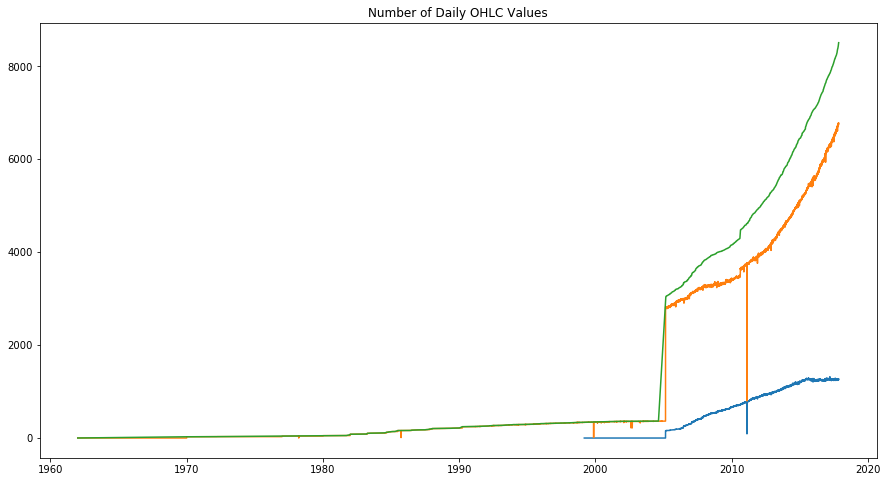

In [11]:
plt.figure(figsize=(15, 8))
plt.plot(cnt_etf.index, cnt_etf.values)
plt.plot(cnt_stock.index, cnt_stock.values)
plt.plot(cnt_min_date.min_date, np.cumsum(cnt_min_date.ticker))
plt.title('Number of Daily OHLC Values')
plt.show()

In [12]:
print('The latest date available is {} and it contains {:,.0f} stocks and {:,.0f} ETFs'.format(
    cnt_stock.index[-1], cnt_stock[-1], cnt_etf[-1]))

The latest date available is 2017-11-10 00:00:00 and it contains 6,764 stocks and 1,261 ETFs


It looks like the amount of data points is generally growing and it contains a couple of extreme jumps. Given that the overall number of listed companies has been going down this most likely implies that the original download process was being actively extended to include additional tickers.

In particular there is a huge jump taking place sometime in 2005 -- such a sharp jump would indicate that a process collecting data was extended to include a much larger universe of stocks and ETFs.

Let's calculate daily percentage change in the number of per day tickers and check for anomalies.

In [13]:
cnt_total = cnt_etf.add(cnt_stock, fill_value=0)
cnt = pd.DataFrame({
    'date': cnt_total.index,
    'total': cnt_total.values
},
                   index=cnt_total.index)

cnt['etf'] = cnt_etf
cnt['etf'] = cnt['etf'].fillna(0)

cnt['stock'] = cnt_stock
cnt['stock'] = cnt['stock'].fillna(0)

cnt['stock_cnt_pct_chg'] = np.abs(cnt['stock'].pct_change())
cnt['etf_cnt_pct_chg'] = np.abs(cnt['etf'].pct_change())

In [14]:
cnt[cnt.stock_cnt_pct_chg > 0.8]

,date,total,etf,stock,stock_cnt_pct_chg,etf_cnt_pct_chg
date,,,,,,
1962-11-12,1962-11-12,2.0,0.0,2.0,1.000000,NaN
1970-01-02,1970-01-02,28.0,0.0,28.0,13.000000,NaN
1978-03-24,1978-03-24,1.0,0.0,1.0,0.976744,NaN
1978-03-27,1978-03-27,43.0,0.0,43.0,42.000000,NaN
1985-09-27,1985-09-27,11.0,0.0,11.0,0.932099,NaN
1985-09-30,1985-09-30,162.0,0.0,162.0,13.727273,NaN
1999-11-16,1999-11-16,14.0,0.0,14.0,0.958944,1.000000
1999-11-17,1999-11-17,344.0,1.0,343.0,23.500000,inf
2005-02-25,2005-02-25,2980.0,157.0,2823.0,6.734247,156.000000


In [15]:
cnt[cnt.etf_cnt_pct_chg > 0.8]

,date,total,etf,stock,stock_cnt_pct_chg,etf_cnt_pct_chg
date,,,,,,
1999-03-10,1999-03-10,338.0,1.0,337.0,0.005900,inf
1999-11-16,1999-11-16,14.0,0.0,14.0,0.958944,1.000000
1999-11-17,1999-11-17,344.0,1.0,343.0,23.500000,inf
2005-02-25,2005-02-25,2980.0,157.0,2823.0,6.734247,156.000000
2011-02-17,2011-02-17,891.0,91.0,800.0,0.787629,0.882883
2011-02-18,2011-02-18,4534.0,781.0,3753.0,3.691250,7.582418


We can see that the two huge jumps observed on the chart took place on 2005-02-25 and 2011-02-17. Let's take a look at them in detail below.

In [16]:
cnt['2005-02-23':'2005-02-28']

,date,total,etf,stock,stock_cnt_pct_chg,etf_cnt_pct_chg
date,,,,,,
2005-02-23,2005-02-23,364.0,1.0,363.0,0.002747,0.000000
2005-02-24,2005-02-24,366.0,1.0,365.0,0.005510,0.000000
2005-02-25,2005-02-25,2980.0,157.0,2823.0,6.734247,156.000000
2005-02-28,2005-02-28,2977.0,156.0,2821.0,0.000708,0.006369


This jump is probably due to the fact that the collection process was extended to include a much 
bigger universe of stocks and ETFs.

In [17]:
cnt['2011-02-16':'2011-02-22']

,date,total,etf,stock,stock_cnt_pct_chg,etf_cnt_pct_chg
date,,,,,,
2011-02-16,2011-02-16,4544.0,777.0,3767.0,0.005069,0.002567
2011-02-17,2011-02-17,891.0,91.0,800.0,0.787629,0.882883
2011-02-18,2011-02-18,4534.0,781.0,3753.0,3.691250,7.582418
2011-02-22,2011-02-22,4553.0,781.0,3772.0,0.005063,0.000000


There does not seem to be a significant trading event taking place on this date (that would somehow affect trading for a large number of stocks and ETFs), therefore this drop is likely due to a one-day issue with the data collection process. In fact let's use Yahoo data to test this theory out.

## Comparison with Yahoo Finance Data

In [18]:
start_date = '2010-01-01'
end_date = '2011-12-31'
example_ticker = 'SPY'

In [19]:
yh_data = web.DataReader(example_ticker, 'yahoo', start_date, end_date)
yh_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,113.389999,111.510002,112.370003,113.330002,118944600.0,92.246048
2010-01-05,113.680000,112.849998,113.260002,113.629997,111579900.0,92.490204
2010-01-06,113.989998,113.430000,113.519997,113.709999,116074400.0,92.555328
2010-01-07,114.330002,113.180000,113.500000,114.190002,131091100.0,92.946060
2010-01-08,114.620003,113.660004,113.889999,114.570000,126402800.0,93.255348


In [20]:
csv_data = equity_data.get_csv_data(example_ticker, start_date, end_date)
csv_data.head()

,date,ticker,price,volume,dayofweek
date,,,,,
2010-01-04,2010-01-04,spy,98.728,136535215,0
2010-01-05,2010-01-05,spy,98.986,128081381,1
2010-01-06,2010-01-06,spy,99.040,133240614,2
2010-01-07,2010-01-07,spy,99.478,150478068,3
2010-01-08,2010-01-08,spy,99.810,145096435,4


Let's make sure that calls return two identical sets of tradning dates.

In [21]:
yh_dates_not_csv = yh_data.index[~yh_data.index.isin(csv_data.index)]
if len(yh_dates_not_csv):
    print('Here is a list of dates returned by Yahoo but not found in csv: {}'.
          format(list(yh_dates_not_csv.strftime('%Y-%m-%d'))))

csv_dates_not_yh = csv_data.index[~csv_data.index.isin(yh_data.index)]
if len(csv_dates_not_yh):
    print('Here is a list of dates returned by Yahoo but not found in csv: {}'.
          format(list(csv_dates_not_yh.strftime('%Y-%m-%d'))))

Here is a list of dates returned by Yahoo but not found in csv: ['2011-02-17']


This confirms our earlier theory that the csv data was not fully downloaded on '2011-02-17'.

The csv data is supposed to be split & dividend adjusted as of '2017-11-10' vs how Yahoo adjusts its data based on the the latest available date. Let's download a new set of dates and compare csv prices vs unadjusted Yahoo prices. Let's use ratios instead of absolute differences to perform this comparison.

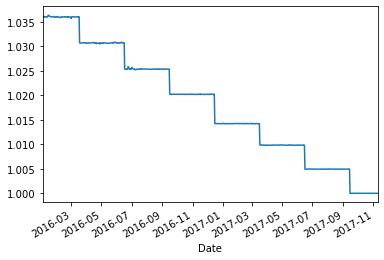

In [22]:
start_date = '2016-01-01'
end_date = '2017-11-10'

yh_data = web.DataReader(example_ticker, 'yahoo', start_date, end_date)
csv_data = equity_data.get_csv_data(example_ticker, start_date, end_date)

abs(yh_data['Close'] / csv_data['price']).plot()

These steps (for the most part) are very smooth and imply that csv data was dividend adjusted (SPY does not have any splits).

There are more checks that should be performed to ensure data quality of csv files, but let's stop here for now.

## Utilizing Dask for Analyzing Data

Given that each ticker is saved into its own file, a more efficient (from usability perspective) would be to calculate basic statistics utilizing a tool like Dask. Here is an example how we could go about in case of analyzing stock data.

In [23]:
# We map stock files to one virtual dataframe. A new column ('path') is created
# which contains a source filename for each data row.

STOCK_DATA_DIR = os.path.join(DATA_DIR, STOCK_DIR)
stocks = dd.read_csv(os.path.join(STOCK_DATA_DIR,
                                  '*' + EquityData.FILE_SUFFIX),
                     include_path_column=True)

# We extract a ticker using the path variable
stocks['ticker'] = stocks['path'].str.replace('.*' + STOCK_DATA_DIR + '/',
                                              '',
                                              regex=True)
stocks['ticker'] = stocks['ticker'].str.replace('.us.txt', '')

stocks = stocks.drop(columns=['Open', 'High', 'Low', 'OpenInt', 'path'])
stocks = stocks.rename(columns={
    'Date': 'date',
    'Close': 'price',
    'Volume': 'volume'
})
stocks.index = stocks.date
stocks = stocks[['ticker', 'price', 'volume']]
stocks.head()

,ticker,price,volume
date,,,
1999-11-18,a,29.702,66277506
1999-11-19,a,27.257,16142920
1999-11-22,a,29.702,6970266
1999-11-23,a,27.002,6332082
1999-11-24,a,27.717,5132147


In [24]:
cnt_stock_dask = stocks.groupby(['date'])['price'].count().compute()

# We need to make sure that index values are sorted
cnt_stock_dask = cnt_stock_dask.sort_index()

In [25]:
if all(cnt_stock == cnt_stock):
    print('Results for both approaches (Dask & Pandas) are matching up - good')

Results for both approaches (Dask & Pandas) are matching up - good


**Conclusion:** In general, using Dask is much more convenient compared to writing custom functions to process data for each ticker and than aggregate results. One should run some performance checks to further examine pros and cons of using Dask.